<h1>
<center>CFRM 421/521</center>
</h1>

<h1>
<center>[Ziwen Chen]</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Tuesday, April 15, 2025, 11:59 PM**


* Total marks: 49


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [10 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit


def load_housing_data ():
    tarball_path = Path ("datasets_HW1/housing.tgz")
    if not tarball_path.is_file ():
        Path ("datasets_HW1").mkdir (parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve (url, tarball_path)
        with tarfile.open (tarball_path) as housing_tarball:
            housing_tarball.extractall (path="datasets_HW1")
    return pd.read_csv (Path ("datasets_HW1/housing/housing.csv"))


housing = load_housing_data ()

Next, we create stratified test and training sets based on different income categories.

In [2]:
housing["income_cat"] = pd.cut (housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

split_obj = StratifiedShuffleSplit (n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split (housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop ("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [3]:
X_raw = strat_train_set.drop ("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy ()
X_raw_test = strat_test_set.drop ("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy ()


## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [4]:
X_raw.shape

(16512, 9)

In [5]:
X_raw[X_raw.isnull ().any (axis=1)].shape

(168, 9)

In [6]:
X_raw[X_raw.isnull ().any (axis=1)].head ()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.

**Solution:**

In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer (strategy="median")
X_raw_new = X_raw.drop ("ocean_proximity", axis=1)
imputer.fit (X_raw_new)

SimpleImputer (strategy='median')

X_raw_fill = imputer.transform (X_raw_new)
X_filled = pd.DataFrame (X_raw_fill, columns=X_raw_new.columns)
X_filled.isnull ().sum ()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**Solution:**

In [8]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal = OrdinalEncoder ()
onehot = OneHotEncoder ()

X_ordinal = ordinal.fit_transform (X_raw[['ocean_proximity']])
X_onehot = onehot.fit_transform (X_raw[['ocean_proximity']])

In [9]:
print ("Ordinal Encoding:\n", X_ordinal)
print ("Categories:", ordinal.categories_)

Ordinal Encoding:
 [[3.]
 [0.]
 [1.]
 ...
 [4.]
 [0.]
 [4.]]
Categories: [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [10]:
print ("One-hot Encoding:\n", X_onehot.toarray ())
print ("Categories:", onehot.categories_)

One-hot Encoding:
 [[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Categories: [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


## (c) Feature engineering [2 marks]

Often it may be useful to experiment with transforming and combining features to create new features that may be expected to better predict the target variable. Features that are skewed or heavily tailed can be logged to make them closer to normal. An example of a feature combination is instead of using the number of bedrooms, which may not be meaningful by itself, we should consider the number of bedrooms relative to the number of rooms.

**Task:** Read the subsections "Custom Transformers" and "Transformation Pipelines" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.FunctionTransformer` class take the log of `population`, and to create the ratio `total_bedrooms/total_rooms`. Print these two transformed features.

**Solution:**

In [11]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer (np.log)
log_population = log_transformer.transform (X_raw[['population']])
log_population.sample (5)

,population
17051,6.785588
17970,7.342779
12676,6.586172
20004,7.462789
3998,8.414939


In [12]:
ratio_bedroom = X_filled['total_bedrooms'] / X_filled['total_rooms']
ratio_bedroom.sample (5)

4962    0.206897
7817    0.281388
1227    0.374892
9914    0.215414
386     0.212054
dtype: float64

In [13]:
X_filled['population'] = log_population
X_filled['ratio_bedroom'] = ratio_bedroom

## (d) Feature scaling and transformation [1 mark]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have a similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1, here we focus on the latter.

**Task:** Read the subsection "Feature Scaling and Transformation" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.StandardScaler` class to scale the numerical features using standardization. 

**Solution:**

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler ()
X_filled_scaled = scaler.fit_transform (X_filled)
X_filled_scaled = pd.DataFrame (X_filled_scaled, columns=X_filled.columns)
X_filled_scaled.sample (5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ratio_bedroom
972,0.721359,-0.786482,0.748715,-0.731918,-0.796269,0.474638,-0.710428,0.068488,-0.295058
4090,0.841325,-0.889612,0.430885,-0.402890,-0.438295,1.794830,-0.444008,-0.338937,-0.197420
3439,-1.263082,0.947978,0.669257,-0.795527,-0.822347,-0.660764,-0.767891,-0.074068,-0.026334
9414,1.226217,-1.381824,0.669257,-0.712698,-0.578166,-0.149055,-0.613785,-0.953089,0.877676
2855,0.761348,-0.781794,0.589800,0.098204,0.355884,0.550361,0.451895,-0.142942,0.413750


## (e) Transformation pipelines [4 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `ColumnTransformer` and `Pipeline` classes provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then create one pipeline that combines the above steps  in the following way applied to the original "raw" features `X_raw`: part (a) (a median imputer for numerical features), part (c) (create the ratios `total_bedrooms/total_rooms`, `total_rooms/households`, `population/households`; and take the log of `total_bedrooms`, `total_rooms`, `population`, `households`, `median_income`), part (d) (a standard scaler for all numerical features, including the transformed features), part (b) (one-hot encoding for categorical variables). Call your transformed features `X`, and print it.

**Solution:**

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


# ----------- 比率特征构造函数 -----------
def add_ratios (df):
    df = df.copy ()
    df["total_bedrooms/total_rooms"] = df["total_bedrooms"] / df["total_rooms"]
    df["total_rooms/households"] = df["total_rooms"] / df["households"]
    df["population/households"] = df["population"] / df["households"]
    return df


# ----------- 设置列名 -----------
log_attributes = ["total_bedrooms", "total_rooms", "population", "households", "median_income"]
ratio_columns = ["total_bedrooms/total_rooms", "total_rooms/households", "population/households"]
num_attributes = X_raw.select_dtypes (include=[np.number]).columns.tolist ()
cat_attributes = X_raw.select_dtypes (exclude=[np.number]).columns.tolist ()

# ----------- 各 pipeline 构造 -----------
# 1. 构造比率特征（作为第一步执行）
ratio_transformer = FunctionTransformer (add_ratios)
# ratio_pipeline = make_pipeline(SimpleImputer(strategy="median"), ratio_transformer, StandardScaler())

# 2. 对数变换指定列
log_pipeline = make_pipeline (
    SimpleImputer (strategy="median"),
    FunctionTransformer (np.log, feature_names_out="one-to-one"),
    StandardScaler ()
)

# 3. 数值列处理（中位数填充 + 标准化）
num_pipeline = make_pipeline (
    SimpleImputer (strategy="median"),
    StandardScaler ()
)

# 4. 类别列处理
cat_pipeline = make_pipeline (
    SimpleImputer (strategy="most_frequent"),
    OneHotEncoder (handle_unknown="ignore")
)

# ----------- 构建完整 ColumnTransformer -----------
preprocessing = make_pipeline (
    ratio_transformer,
    ColumnTransformer ([
        ("log", log_pipeline, log_attributes),
        ("std", num_pipeline, num_attributes + ratio_columns),
        ("cat", cat_pipeline, cat_attributes),
    ]),
)

In [16]:
# ----------- 应用 pipeline -----------
X = preprocessing.fit_transform (X_raw)
X = pd.DataFrame (X, columns=preprocessing[1].get_feature_names_out ())
X

,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,std__longitude,std__latitude,std__housing_median_age,std__total_rooms,std__total_bedrooms,...,std__households,std__median_income,std__total_bedrooms/total_rooms,std__total_rooms/households,std__population/households,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
0,1.324114,0.637892,0.456906,1.310369,-1.071522,-1.423037,1.013606,1.861119,0.311912,1.368167,...,1.394812,-0.936491,2.153743,-0.866027,-0.330204,0.0,0.0,0.0,1.0,0.0
1,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,0.596394,-0.702103,0.907630,-0.308620,-0.435925,...,-0.373485,1.171942,-0.569651,0.024550,-0.253616,1.0,0.0,0.0,0.0,0.0
2,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,-1.203098,1.276119,0.351428,-0.712240,-0.760709,...,-0.775727,-0.759789,-0.215784,-0.041193,-0.051041,0.0,1.0,0.0,0.0,0.0
3,0.952773,0.943475,0.670700,0.925373,-0.912253,1.231216,-0.884924,-0.919891,0.702262,0.742306,...,0.731375,-0.850281,-0.154314,-0.034858,-0.141475,0.0,1.0,0.0,0.0,0.0
4,1.437622,1.003590,0.719093,1.481464,0.034537,0.711362,-0.875549,0.589800,0.790125,1.595753,...,1.755263,-0.180365,1.132023,-0.666554,-0.306148,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.465581,0.109720,-0.247054,0.379471,0.648953,0.586397,-0.833359,0.987087,-0.184147,0.140152,...,0.060101,0.444041,0.948316,-0.452111,-0.269780,1.0,0.0,0.0,0.0,0.0
16508,0.454022,0.477277,0.314542,0.402773,-0.637675,0.131525,0.319822,-0.443146,0.139847,0.128298,...,0.083608,-0.685630,-0.204419,0.036792,-0.073741,0.0,1.0,0.0,0.0,0.0
16509,0.824206,0.859552,1.243381,0.889897,0.333540,1.256209,-1.428701,-1.237721,0.586026,0.562134,...,0.679135,0.101049,-0.262436,-0.109987,0.158542,0.0,0.0,0.0,0.0,1.0
16510,0.987851,0.811293,0.579462,1.023329,0.377051,0.586397,-0.739605,0.669257,0.522417,0.794461,...,0.882868,0.145396,0.318463,-0.360937,-0.210332,1.0,0.0,0.0,0.0,0.0


# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(e) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**Solution:**

In [17]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression ()
linear_reg.fit (X, y)

prediction = linear_reg.predict (X[:10])
prediction

array([281722.05638333, 360208.40402039, 118472.69784906, 109291.57628192,
       299676.83863223, 186576.21268178, 313822.05471067, 326683.26699456,
       157407.69854484, 118869.95761567])

## (b) RMSE and MAE  [2 marks]

We can measure the performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**Solution:**

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = linear_reg.predict (X)
linear_mse = mean_squared_error (y, y_pred)
linear_rmse = np.sqrt (linear_mse)
float (linear_rmse)

65342.15993950135

In [19]:
linear_mae = mean_absolute_error (y, y_pred)
linear_mae

47468.52588936734

## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**Solution:**

In [20]:
from sklearn.model_selection import cross_val_score

cv_lin = -cross_val_score (linear_reg, X, y, scoring='neg_root_mean_squared_error', cv=10)

print ("CV Scores(RMSE):\n", cv_lin)
print ("Mean(RMSE):", cv_lin.mean ())

CV Scores(RMSE):
 [66416.63231213 65331.7210065  62886.34316559 71134.0057904
 64880.91492603 67495.39993749 65005.83129633 66656.66125675
 64905.62469604 65748.3569513 ]
Mean(RMSE): 66046.1491338548


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [21]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor (random_state=42)
dt_reg.fit (X, y)

DecisionTreeRegressor(random_state=42)

In [22]:
dt_reg.predict (X[:10])

array([458300., 483800., 101700.,  96100., 361800.,  92600., 349300.,
       440900., 160100., 183900.])

The following code does the same for the random forest model.

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor (bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit (X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [24]:
rf_reg.predict (X[:10])

array([226052.57663663, 408572.3162281 , 101364.54688025,  93651.87639325,
       323566.08786234, 134867.05139342, 283371.7148996 , 357336.26089032,
       167683.79883233, 146388.2229703 ])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**Solution:**

In [25]:
tree_mse = mean_squared_error (y, dt_reg.predict (X))
tree_rmse = np.sqrt (tree_mse)
float (tree_rmse)

0.0

In [26]:
forest_mse = mean_squared_error (y, rf_reg.predict (X))
forest_rmse = np.sqrt (forest_mse)
forest_rmse

np.float64(62135.575556569696)

In [27]:
cv_tree = -cross_val_score (dt_reg, X, y, scoring='neg_root_mean_squared_error', cv=10)

print ("CV Scores:\n", cv_tree)
print ("Mean:", cv_tree.mean ())

CV Scores:
 [67517.64533276 68141.2671543  70358.5034772  71893.83370422
 69616.23703764 71188.44431449 71666.05665422 75019.73162396
 69220.70348669 69876.34025968]
Mean: 70449.87630451504


In [28]:
cv_forest = -cross_val_score (rf_reg, X, y, scoring='neg_root_mean_squared_error', cv=10)

print ("CV Scores:\n", cv_forest)
print ("Mean:", cv_forest.mean ())

CV Scores:
 [64312.89632128 64357.65527495 61202.01260907 62702.5094896
 62975.33236698 64213.19793503 64032.28636755 64726.66486969
 63753.37971511 64639.36288584]
Mean: 63691.5297835107


In [29]:
result = {
    "Model": ["Linear regression", "Decision tree", "Random forest"],
    "In Sample": [linear_rmse, tree_rmse, forest_rmse],
    "Out of Sample": [cv_lin.mean (), cv_tree.mean (), cv_forest.mean ()]
}

summary_df = pd.DataFrame (result)

summary_df

,Model,In Sample,Out of Sample
0,Linear regression,65342.159940,66046.149134
1,Decision tree,0.000000,70449.876305
2,Random forest,62135.575557,63691.529784


The best in sample is decision tree; the best out of sample is random forest

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has hyperparameter including `n_estimators` and `max_features`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `max_features` over the values 4, 6, 8, 10 and `n_estimators` over the values 10, 50, 100. Use 3-fold cross-validation with RMSE when searching for the best hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search with 10 iterations, where  `max_features` is a uniform random integer between 2 and 20 and `n_estimators` is a uniform random integer between 10 and 200. `RandomizedSearchCV` must include the argument `random_state=42`.


In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**Solution:**

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

In [31]:
param_grid = [
    {'max_features': [4, 6, 8, 10],
     'n_estimators': [10, 50, 100]}
]

forest_model = RandomForestRegressor (random_state=42)

grid_search = GridSearchCV (forest_model, param_grid, cv=3,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1)

grid_search.fit (X, y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [4, 6, 8, 10],
                          'n_estimators': [10, 50, 100]}],
             scoring='neg_root_mean_squared_error')

In [32]:
grid_search.best_score_

np.float64(-50783.86888421842)

In [33]:
param_distribs = [
    {'max_features': randint (low=2, high=20),
     'n_estimators': randint (low=10, high=200)}
]

rnd_search = RandomizedSearchCV (forest_model, param_distribs, n_iter=10, cv=3,
                                 scoring='neg_root_mean_squared_error',
                                 random_state=42, n_jobs=-1)

rnd_search.fit (X, y)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions=[{'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11a5df0e0>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11a5df1a0>}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [34]:
rnd_search.best_score_

np.float64(-50692.82579977411)

In [35]:
searches = [grid_search, rnd_search]
best_index = np.argmax ([grid_search.best_score_, rnd_search.best_score_])
best_model = searches[best_index]
print ("Best hyperparameter values:", searches[best_index].best_params_)

Best hyperparameter values: {'max_features': 8, 'n_estimators': 131}


## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**Solution:**

In [36]:
X_test = preprocessing.transform (X_raw_test)
X_test = pd.DataFrame (X_test, columns=preprocessing[1].get_feature_names_out ())
y_test = strat_test_set["median_house_value"].copy ()

In [37]:
y_pred = best_model.predict (X_test)

test_rmse = np.sqrt (mean_squared_error (y_test, y_pred))

print ("The RMSE of best model:", test_rmse)

The RMSE of best model: 50480.692357932334


# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**Solution:**

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

poly_term = make_pipeline (PolynomialFeatures (degree=3, include_bias=False), StandardScaler ())
X_poly = poly_term.fit_transform (X)

poly_reg = LinearRegression ()
poly_reg.fit (X_poly, y)

ridge_reg = Ridge (alpha=1, solver='cholesky')
ridge_reg.fit (X_poly, y)

Ridge(alpha=1, solver='cholesky')

## (b) Learning curves [4 marks]

Obtain learning curves using the function `sklearn.model_selection.learning_curve` to plot the learning curve with 5-fold CV for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither.

**Solution:**

In [90]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


def plot_learning_curve (
        estimator,
        X, y,
        title="Learning Curve",
        train_sizes=np.linspace (0.1, 1.0, 10),
        cv=5,
        scoring='neg_root_mean_squared_error',
        figsize=(8, 6),
        color_train='royalblue',
        color_val='darkorange'
):
    train_sizes, train_scores, val_scores = learning_curve (
        estimator, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring
    )

    train_mean = -np.mean (train_scores, axis=1)
    val_mean = -np.mean (val_scores, axis=1)

    plt.figure (figsize=figsize)
    plt.plot (train_sizes, train_mean, '--', color=color_train, linewidth=2.5, label="Training error")
    plt.plot (train_sizes, val_mean, '--', color=color_val, linewidth=2.5, label="Validation error")

    plt.title (title)
    plt.xlabel ("Training set size")
    plt.ylabel ("Root Mean Squared Error")
    plt.ylim(0, 500000)
    plt.legend (loc="best", fontsize=12)
    plt.grid (True, linestyle='--')
    plt.tight_layout ()
    plt.show ()

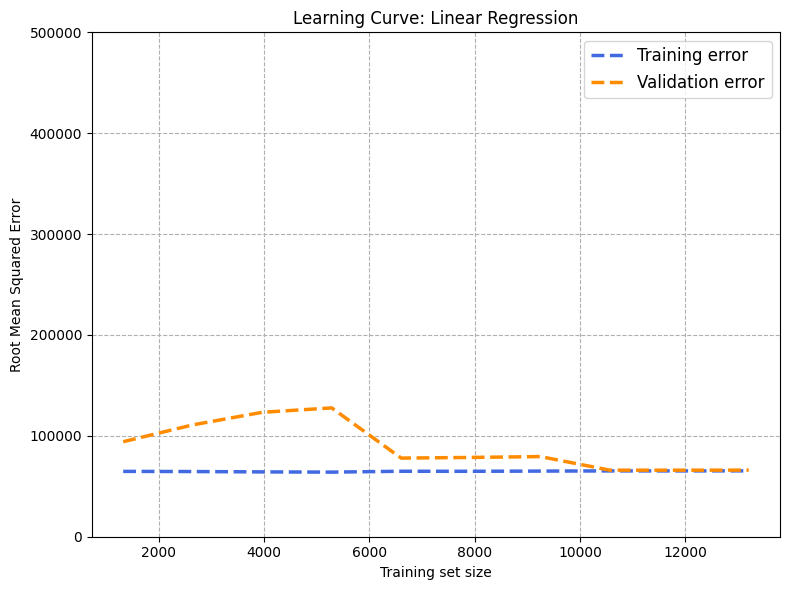

In [91]:
plot_learning_curve (linear_reg, X, y, title="Learning Curve: Linear Regression")

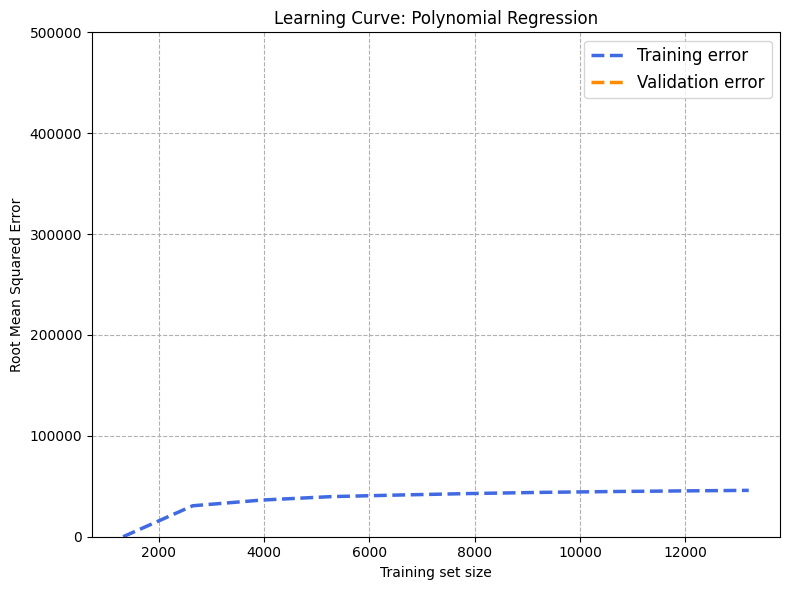

In [92]:
plot_learning_curve (poly_reg, X_poly, y, title="Learning Curve: Polynomial Regression")

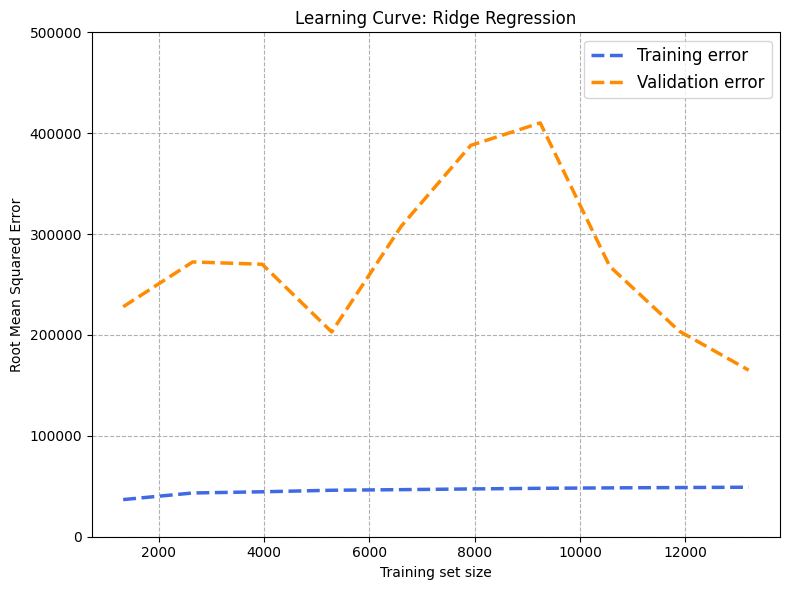

In [93]:
plot_learning_curve (ridge_reg, X_poly, y, title="Learning Curve: Ridge Regression")

Among the three models, linear regression performs the best — its validation error gradually approaches the training error as the training set size increases, indicating a good fit. Ridge regression performs slightly worse but still shows a converging trend, suggesting it is close to an appropriate fit or slightly underfitting. In contrast, the polynomial regression performs the worst, showing no sign of convergence; its validation error remains significantly higher than its training error, indicating severe overfitting or poor generalization. In summary, linear regression is well-fitted or mildly overfitting, ridge regression is close to a good fit or slightly underfitting, and polynomial regression fails to fit the data properly.

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/104571273/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then use `sklearn.model_selection.train_test_split` to split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [43]:
import os

data = pd.read_csv ("datasets_HW1/Default.csv")

**Solution:**

In [44]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split (data, test_size=0.2, random_state=42)

default = train_set.copy ()
default.head ()

,default,student,balance,income
9254,No,No,1018.568130,34103.879520
1561,No,No,62.170050,28660.747508
1670,No,No,1046.743543,40822.447413
6087,No,No,763.735280,44125.718725
6669,No,Yes,697.248633,25730.917583


## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**Solution:**

In [45]:
y_train = default['default'] == "Yes"
X_train_raw = default.drop ('default', axis=1)
X_train_raw.head ()

,student,balance,income
9254,No,1018.568130,34103.879520
1561,No,62.170050,28660.747508
1670,No,1046.743543,40822.447413
6087,No,763.735280,44125.718725
6669,Yes,697.248633,25730.917583


In [46]:
from sklearn.compose import make_column_selector

preprocessing2 = ColumnTransformer ([
    ("num", StandardScaler (), make_column_selector (dtype_include=float)),
    ("cat", OneHotEncoder (), make_column_selector (dtype_include=object))
])

X_train = preprocessing2.fit_transform (X_train_raw)
X_train = pd.DataFrame (X_train, columns=preprocessing2.get_feature_names_out ())
X_train

,num__balance,num__income,cat__student_No,cat__student_Yes
0,0.381082,0.037308,1.0,0.0
1,-1.591774,-0.370099,1.0,0.0
2,0.439202,0.540178,1.0,0.0
3,-0.144587,0.787420,1.0,0.0
4,-0.281735,-0.589390,0.0,1.0
...,...,...,...,...
7995,0.065740,-0.004819,1.0,0.0
7996,-0.701760,-0.980897,0.0,1.0
7997,-0.230618,-0.495580,1.0,0.0
7998,-1.381844,-0.937276,0.0,1.0


## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC. Use the default arguments, except you must include the argument `random_state=42`.  Furthermore, for the logistic regression, compute the ROC AUC for `C` taking the values 0.001, 0.01, 0.1, 1, 10, 100, to show that the default value of 1 is approximately optimal.

**Solution:**

In [47]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

In [48]:
log_reg = LogisticRegression (random_state=42)
log_reg.fit (X_train, y_train)

LogisticRegression(random_state=42)

In [49]:
SGD = SGDClassifier (random_state=42)
SGD.fit (X_train, y_train)

SGDClassifier(random_state=42)

In [50]:
log_scores = cross_val_predict (log_reg, X_train, y_train, cv=10, method='decision_function')

SGD_scores = cross_val_predict (SGD, X_train, y_train, cv=10, method='decision_function')

In [51]:
fpr, tpr, thresholds = roc_curve (y_train, log_scores)

fpr2, tpr2, thresholds2 = roc_curve (y_train, SGD_scores)

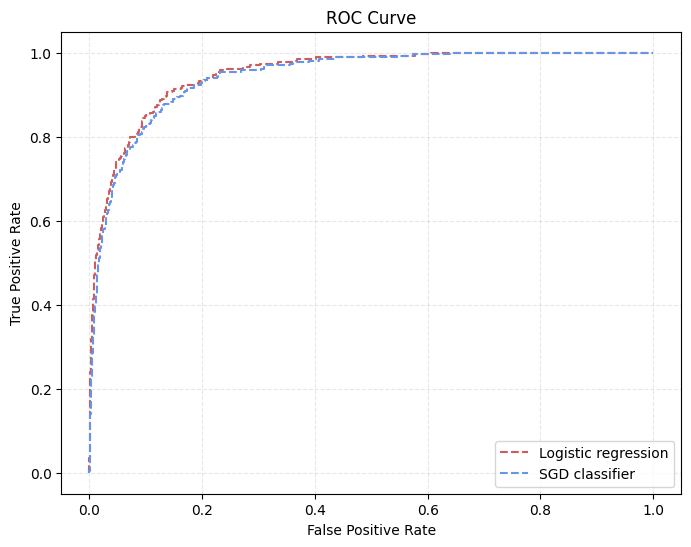

In [52]:
plt.figure (figsize=(8, 6))
plt.plot (fpr, tpr, '--', color='indianred', label="Logistic regression")
plt.plot (fpr2, tpr2, '--', color='cornflowerblue', label="SGD classifier")
plt.title ('ROC Curve')
plt.xlabel ("False Positive Rate")
plt.ylabel ("True Positive Rate")
plt.legend (loc="best")
plt.grid (True, linestyle='--', alpha=0.3)
plt.show ()

In [53]:
roc_auc_log = roc_auc_score (y_train, log_scores)
roc_auc_sgd = roc_auc_score (y_train, SGD_scores)

print ("ROC AUC——logistic regression:", roc_auc_log)
print ("ROC AUC——SGD classifier:", roc_auc_sgd)

ROC AUC——logistic regression: 0.9501484597787597
ROC AUC——SGD classifier: 0.9433360557488014


In [54]:
param_grid = [
    {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
]

grid_search = GridSearchCV (log_reg, param_grid, cv=10,
                            scoring='roc_auc', n_jobs=-1)
grid_search.fit (X_train, y_train)

grid_search.best_params_

{'C': 1}

The result shows that C = 1 is indeed the approximately optimal!

## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 75%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve a 75% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**Solution:**

In [55]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


def plot_precision_recall_curve (precisions, recalls, thresholds, title="Precision-Recall vs Threshold"):
    plt.figure (figsize=(8, 4))
    plt.plot (thresholds, precisions[:-1], '--', color='indianred', markersize=3, alpha=0.7, label="Precision")
    plt.plot (thresholds, recalls[:-1], '--', color='cornflowerblue', label="Recall")
    plt.title (title, fontsize=14)
    plt.xlabel ("Decision Threshold", fontsize=12)
    plt.ylabel ("Metric Value", fontsize=12)
    plt.legend (loc="best", fontsize=12)
    plt.grid (True, linestyle='--', alpha=0.6)
    plt.show ()


# helper method
def find_threshold_for_target_recall (precisions, recalls, thresholds, target_recall=0.75):
    """
    Finds the highest threshold for which recall is at least the target recall.
    """
    for i in reversed (range (len (thresholds))):
        if recalls[i] >= target_recall:
            print (f"Target Recall: {recalls[i]:.3f}")
            print (f"Threshold at Target Recall: {thresholds[i]:.3f}")
            print (f"Corresponding Precision: {precisions[i]:.3f}")
            return thresholds[i], precisions[i]

    # If no threshold satisfies the target recall, return the first
    print (f"Target Recall not met. Using first available point.")
    print (f"Recall: {recalls[0]:.3f}, Threshold: {thresholds[0]:.3f}, Precision: {precisions[0]:.3f}")
    return thresholds[0], precisions[0]

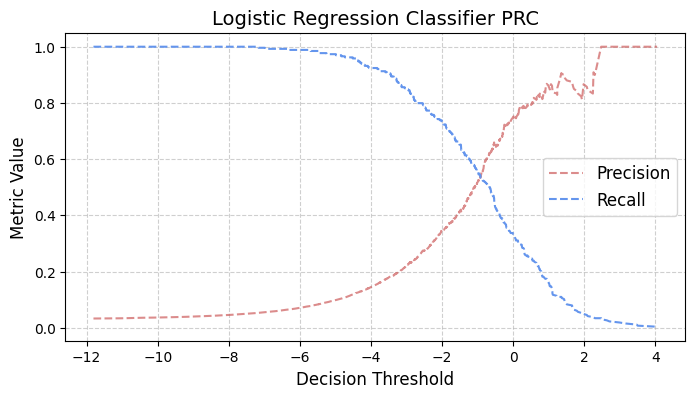

In [56]:
precisions_log, recalls_log, thresholds_log = precision_recall_curve (y_train, log_scores)
plot_precision_recall_curve (precisions_log, recalls_log, thresholds_log, "Logistic Regression Classifier PRC")

In [57]:
find_threshold_for_target_recall(precisions_log, recalls_log, thresholds_log)

Target Recall: 0.750
Threshold at Target Recall: -2.147
Corresponding Precision: 0.323


(np.float64(-2.1474459152526224), np.float64(0.32300163132137033))

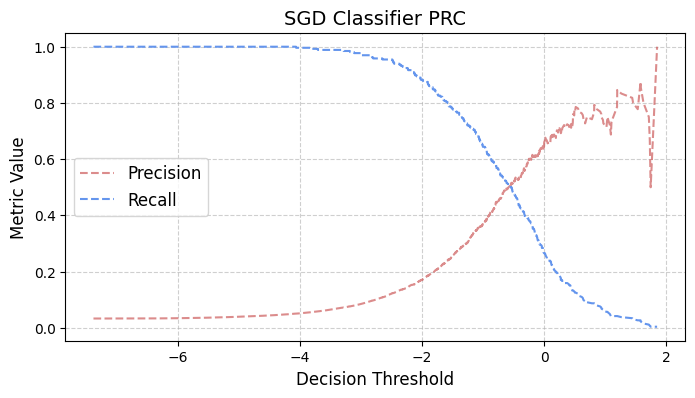

In [58]:
precisions_SGD, recalls_SGD, thresholds_SGD = precision_recall_curve(y_train, SGD_scores)
plot_precision_recall_curve(precisions_SGD, recalls_SGD, thresholds_SGD, "SGD Classifier PRC")

In [59]:
find_threshold_for_target_recall(precisions_SGD, recalls_SGD, thresholds_SGD)

Target Recall: 0.750
Threshold at Target Recall: -1.348
Corresponding Precision: 0.288


(np.float64(-1.3484894484634484), np.float64(0.2877906976744186))

In [60]:
log_reg_balance = LogisticRegression(class_weight="balanced")
log_reg_balance.fit(X_train, y_train)
log_balance_scores = cross_val_predict(log_reg_balance, X_train, y_train, cv=10, method='decision_function')

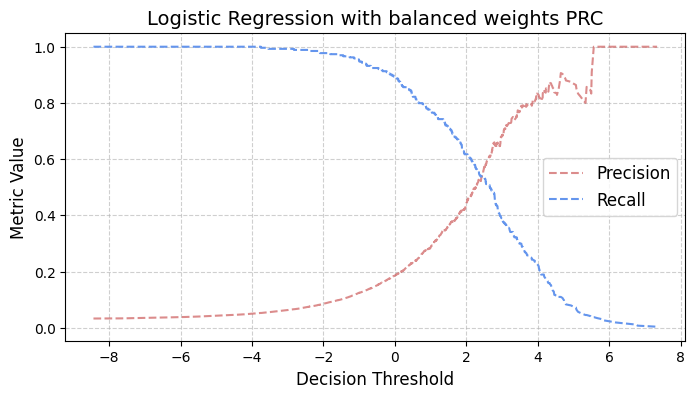

In [61]:
precisions_log_bal, recalls_log_bal, thresholds_log_bal = precision_recall_curve(y_train, log_balance_scores)
plot_precision_recall_curve(precisions_log_bal, recalls_log_bal, thresholds_log_bal, "Logistic Regression with balanced weights PRC")

In [62]:
find_threshold_for_target_recall(precisions_log_bal, recalls_log_bal, thresholds_log_bal)

Target Recall: 0.750
Threshold at Target Recall: 1.200
Corresponding Precision: 0.321


(np.float64(1.2004367837009167), np.float64(0.3209076175040519))

In [63]:
SGD_balance = SGDClassifier(class_weight="balanced", random_state=42)
SGD_balance.fit(X_train, y_train)
SGD_balance_scores = cross_val_predict(SGD_balance, X_train, y_train, cv=10, method="decision_function")

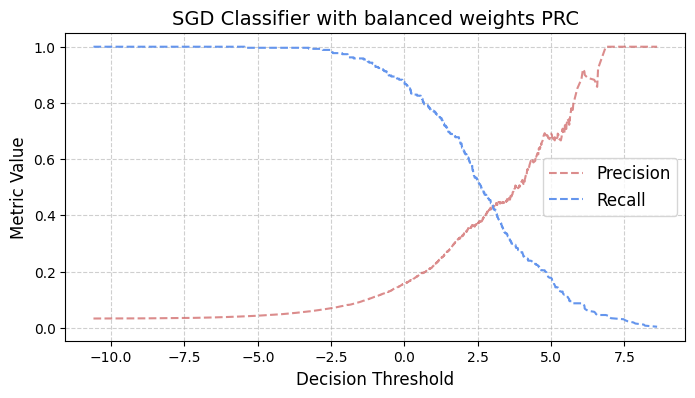

In [64]:
precisions_SGD_bal, recalls_SGD_bal, thresholds_SGD_bal = precision_recall_curve(y_train, SGD_balance_scores)
plot_precision_recall_curve(precisions_SGD_bal, recalls_SGD_bal, thresholds_SGD_bal, "SGD Classifier with balanced weights PRC")

In [65]:
find_threshold_for_target_recall(precisions_SGD_bal, recalls_SGD_bal, thresholds_SGD_bal)

Target Recall: 0.750
Threshold at Target Recall: 1.217
Corresponding Precision: 0.245


(np.float64(1.217325628307532), np.float64(0.24504950495049505))

logisic regress classifier has the highest precision.

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**Solution:**

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_test = test_set["default"].values=="Yes"
X_test_raw = test_set.drop("default", axis=1)
X_test = preprocessing2.transform(X_test_raw)
X_test = pd.DataFrame(X_test, columns=preprocessing2.get_feature_names_out())
best_threshold, best_precision = find_threshold_for_target_recall(precisions_log, recalls_log, thresholds_log)

Target Recall: 0.750
Threshold at Target Recall: -2.147
Corresponding Precision: 0.323


In [67]:
y_scores = log_reg.decision_function(X_test)

y_pred = y_scores > best_threshold

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("ROC_AUC Score:", roc_auc_score(y_test, y_scores))

Accuracy Score: 0.933
Precision Score: 0.2903225806451613
Recall Score: 0.6521739130434783
ROC_AUC Score: 0.9434925209585783


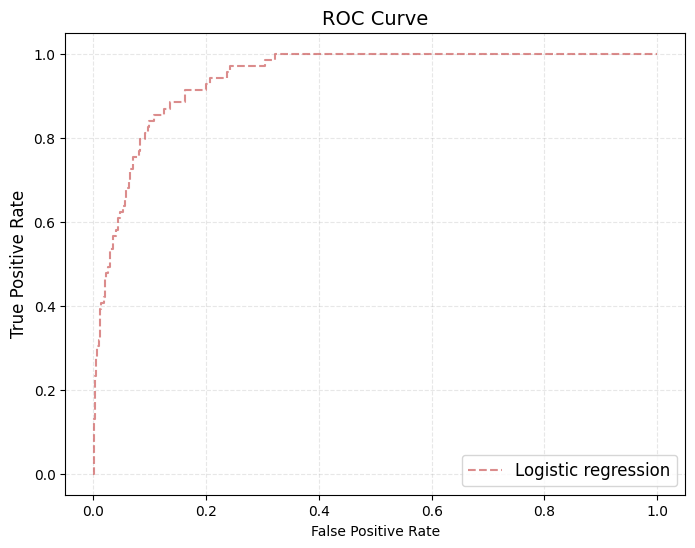

In [68]:
fpr_D, tpr_D, thresholds_D = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr_D, tpr_D, '--', color='indianred', markersize=5, alpha=0.7, label="Logistic regression")
plt.title('ROC Curve', fontsize=14)
plt.xlabel("False Positive Rate",)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()